# Game Flow Incorporating Momentum
Takes in the game flow array of probabilities and modifies them according to various explanatory variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Functions

# Probability Functions

def prob_hold_to_love(p):
    """Probability server holds at love."""
    return p**4

def prob_hold_to_15(p):
    """Probability server holds to 15."""
    q = 1-p
    return 4*(p**4)*q

def prob_hold_to_30(p):
    """Probability server holds to 30."""
    q = 1-p
    return 10*(p**4)*(q**2)

def prob_get_to_deuce(p):
    """Probability game gets to deuce at least once."""
    q = 1-p
    return 20*(p**3)*(q**3)

def prob_hold_via_deuce(p):
    """Probability server holds from deuce."""
    q = 1-p
    d = (p**2) / (1 - 2*p*q)
    return d*prob_get_to_deuce(p)

def prob_hold(p):
    """Probability server holds."""
    return (
        prob_hold_to_love(p) +
        prob_hold_to_15(p) + 
        prob_hold_to_30(p) + 
        prob_hold_via_deuce(p)
    )

# working on probability of winning a series of games
def prob_six_zero(ps):
    """Probability server wins 6-0."""
    return ps**6

def prob_six_one(ps):
    """Probability server wins 6-1."""
    qs = 1-ps
    return 6*(ps**6)*qs

def prob_six_two(ps):
    """Probability server wins 6-2."""
    qs = 1-ps
    return 21*(ps**6)*(qs**2)

def prob_six_three(ps):
    """Probability server wins 6-3."""
    qs = 1-ps
    return 56*(ps**6)*(qs**3)

def prob_six_four(ps):
    """Probability server wins 6-4."""
    qs = 1-ps
    return 126*(ps**6)*(qs**4)

def prob_seven_five(ps):
    """Probability server wins 7-5."""
    qs = 1-ps
    return 42*(ps**7)*(qs**5)

def prob_tiebreaker(ps):
    """Probability server wins 7-6."""
    qs = 1-ps
    return 924*(ps**7)*(qs**6)

def prob_win_set(ps):
    """Probability server holds."""
    return (
        prob_six_zero(ps) +
        prob_six_one(ps) + 
        prob_six_two(ps) + 
        prob_six_three(ps) +
        prob_six_four(ps) +
        prob_seven_five(ps) +
        prob_tiebreaker(ps)
    )

# Calculate the probability of winning a match
def prob_three_zero(pm):
    """Probability player1 wins 3-0."""
    qm = 1-pm
    return pm**3

def prob_three_one(pm):
    """Probability player1 wins 3-1."""
    qm = 1-pm
    return 3*(pm**3)*qm

def prob_three_two(pm):
    """Probability player1 wins 3-2."""
    qm = 1-pm
    return 6*(pm**3)*(qm**2)

def prob_win_match(pm):
    """Probability server holds."""
    return (
        prob_three_zero(pm) +
        prob_three_one(pm) + 
        prob_three_two(pm) 
    )

def get_serve_probability(match_data, player):
    serve_no = match_data['server'].values
    point_victor = match_data['point_victor'].values

    serve_point_won = 0
    num_serves = 0

    p_array = []

    for index in range(len(serve_no)):
        if player == serve_no[index]:
            num_serves += 1

            if player == point_victor[index]:
                serve_point_won += 1

        if num_serves == 0:
            p_array.append(0)
        else:
            p_array.append(serve_point_won / num_serves)

    return p_array

def prob_win_independent_game(p1, p2):
    p1_holds_game = prob_hold(p1)
    p1_concedes_game = (1 - p1_holds_game)

    p2_holds_game = prob_hold(p2)
    p2_concedes_game = (1 - p2_holds_game)

    ps1 = (p1_holds_game + p2_concedes_game) / 2 # Prob p1 wins any independent game
    ps2 = (p2_holds_game + p1_concedes_game) / 2 # Prob p2 wins any independent game

    return ps1, ps2

# Momentum Modifier Functions

# change probability if player wins set
def modify_momentum(match_data, probability_array, player):
    # n = number of sets won
    n = 0
    x = 1.5

    for index in range(len(probability_array)):
        set_victor_array = match_data['set_victor'].values
        won_set = set_victor_array[index] == player

        if (won_set):
            n += 1

        if (n > 0):
            probability_array[index] = (((x**n)-1)/(x**n) + (1/(x**n))*probability_array[index])

        

    return probability_array

def modify_momentum_err(match_data, momentum_array, player):
    array = []

    # unforced error total
    n = 0
    x = 1.001

    unf_err_array = match_data[f'p{player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err = unf_err_array[index] == 1

        if (unf_err):
            n += 1

        if (n > 0):
            array.append (((x**n) - 1) / (x**n) + (1 / (x**n)) * momentum_array[index])
        
    return array

In [22]:
# 1 - Calculate serve probability (points_on_serves / total serves)
# 2 - Calculate probability of winning a game from serve probability for each player
# 3 - Calculate probability of winning a set from the player win game probability
# 4 - Calculate probability of winning a match from the player win set probability
# 5 - Graph the probability of winning the set as point values increase
import numpy as np

class MarkovChain:
    def __init__(self, file, match_to_examine):
        raw_data = pd.read_csv(file)
        self.match = raw_data[raw_data['match_id'] == match_to_examine]
        self.player1_name = self.match['player1'].values[0]
        self.player2_name = self.match['player2'].values[0]
        self.max_length = 0
        self.p1_momentum = []
        self.p2_momentum = []

    # 1 - Get serve probabilities
    def get_serve_probabilities(self, debug=False):
        p1_probability = get_serve_probability(self.match, 1)
        p2_probability = get_serve_probability(self.match, 2)
    
        if debug:
            print("Probability of winning a serve")
            print(p1_probability)
            print(p2_probability)
    
        # Get the maximum length between both probability arrays
        self.max_length = max(len(p1_probability), len(p2_probability))

        return p1_probability, p2_probability
    

    #  2 - Get probability of winning the game
    def get_game_probabilities(self, p1_probability, p2_probability, debug=False):
        pg1_array = []
        pg2_array = []

        for index in range(self.max_length):
            pg1, pg2 = prob_win_independent_game(p1_probability[index], p2_probability[index])

            pg1_array.append(pg1)
            pg2_array.append(pg2)

        if debug:
            print("Probability of winning the game")
            print(pg1_array)
            print(pg2_array)

        return pg1_array, pg2_array
    
    # 3 - Get probability of winning the set.
    def get_set_probabilities(self, pg1_array, pg2_array, debug=False):
        ps1_array = []
        ps2_array = []

        for index in range(self.max_length):
            ps1_array.append(prob_win_set(pg1_array[index]))
            ps2_array.append(prob_win_set(pg2_array[index]))

        if debug:
            print("Probability of winning the set")
            print(ps1_array)
            print(ps2_array)

        return ps1_array, ps2_array
    
    # 4 - Get probability of winning the match
    def get_match_probabilities(self, ps1_array, ps2_array, debug=False):
        pm1_array = []
        pm2_array = []

        for index in range(self.max_length):
            pm1_array.append(prob_win_match(ps1_array[index]))
            pm2_array.append(prob_win_match(ps2_array[index]))

        if debug:
            print("Probability of winning the match")
            print(pm1_array)
            print(pm2_array)

        return pm1_array, pm2_array
    
    def update_momentum(self, pm1_array, pm2_array, debug=False):
        p1_momentum = modify_momentum(self.match,  pm1_array, 1)
        p2_momentum = modify_momentum(self.match, pm2_array, 2)

        p1_momentum1 = modify_momentum_err(self.match, p1_momentum, 1)
        p2_momentum2 = modify_momentum_err(self.match, p2_momentum, 2)

        if debug:
            print(p1_momentum1)
            print(p2_momentum2)

        return p1_momentum1, p2_momentum2
    
    # 5 - Graph
    def graph_momentum(self):
        # graph the performance of match flow + momentum
        set_change_points = []

        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry

        plt.title("Game Flow")
        plt.plot(range(len(self.p1_momentum)), self.p1_momentum, color="red", label=f"{self.player1_name}")
        plt.plot(range(len(self.p2_momentum)), self.p2_momentum, color="blue", label=f"{self.player2_name}")
        plt.xlabel("Point Number")
        plt.ylabel("Performance Rate")
        plt.legend()

        plt.text(20, -.04, 'Set 1', verticalalignment='bottom')
        for index, value in enumerate(set_change_points):
            plt.axvline(x=value, color='gray', linestyle='--')
            plt.text(value + 20, -.04, f"Set {index + 2}", verticalalignment='bottom')

        plt.show()

    def prediction(self):
        # Find who was performing better before sets 3 and 5
        set_change_points = []

        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry
        for index, value in enumerate(set_change_points):
            if index == 1:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_3_pred = self.player1_name
                    print(self.player1_name, "is winning going into set 3 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_3_pred = self.player2_name
                    print(self.player2_name, "is winning going into set 3 with: ", self.p2_momentum[value], "momentum")

            elif index == 2:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_4_pred = self.player1_name
                    print(self.player1_name, "is winning going into set 4 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_4_pred = self.player2_name
                    print(self.player2_name, "is winning going into set 4 with: ", self.p2_momentum[value], "momentum")

            elif index == 3:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_5_pred = self.player1_name
                    print(self.player1_name, "is winning going into set 5 with: ", self.p1_momentum[value], "momentum")
                elif self.p1_momentum[value] < self.p2_momentum[value]:
                    set_5_pred = self.player2_name
                    print(self.player2_name, "is winning going into set 5 with: ", self.p2_momentum[value], "momentum")
                else: 
                    set_5_pred = 0

        set_victors = self.match['set_victor']
        final_point = set_victors.iloc[-1]
        if final_point == 1:
            winner = self.player1_name
        else:
            winner = self.player2_name
        print(winner, "won the game")

        verbose = False
        if verbose:
            for index, value in enumerate(set_change_points):
                if index == 1:
                    if winner == set_3_pred:
                        print("set 3 prediction is correct")
                    else:
                        print("set 3 prediction is wrong")
    
                elif index == 2:
                    if winner == set_4_pred:
                        print("set 4 prediction is correct")
                    else:
                        print("set 4 prediction is wrong")
                        
                elif index == 3:
                    if winner == set_5_pred:
                        print("set 5 prediction is correct")
                    else:
                        print("set 5 prediction is wrong")
            #

        self.set_change_points = set_change_points
        
        data = np.vstack([self.p1_momentum[self.set_change_points], self.p2_momentum[self.set_change_points]])
        data = data.T
        
        return data, final_point
        
    #
    
    def train(self, debug=False):        
        self.p1_momentum, self.p2_momentum = self.update_momentum(
            *self.get_match_probabilities( # 4
                *self.get_set_probabilities( # 3
                    *self.get_game_probabilities( # 2
                        *self.get_serve_probabilities(debug), debug), debug), debug), debug) # 1
        self.p1_momentum = np.array(self.p1_momentum)
        self.p2_momentum = np.array(self.p2_momentum)
        return


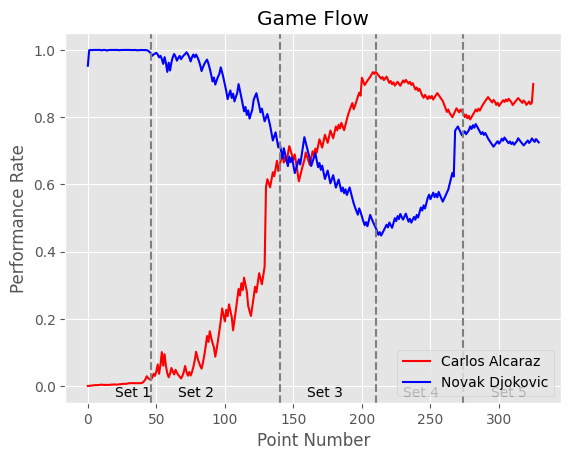

Novak Djokovic is winning going into set 3 with:  0.7229720989184008 momentum
Carlos Alcaraz is winning going into set 4 with:  0.9353378046673034 momentum
Carlos Alcaraz is winning going into set 5 with:  0.8113187577861737 momentum
Carlos Alcaraz won the game


In [23]:
MATCH_TO_EXAMINE = '2023-wimbledon-1701'
FILE = '2023-wimbledon-data.csv'

model = MarkovChain(FILE, MATCH_TO_EXAMINE)
model.train()
model.graph_momentum()
data, win = model.prediction()

array([[0.01927184, 0.98979656],
       [0.65858359, 0.7229721 ],
       [0.9353378 , 0.47198532],
       [0.81131876, 0.75193002]])

In [30]:
import numpy as np

# TODO: logistic regression in 1D
# TODO: ROC curve; https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# TODO: shift winner index to refer to player 0 and player 1.

# all for one match; compile, pick a set, and evaluate.
predicted_winner = 1/2*( 1 + np.diff(data, axis=1) )
predicted_winner

actual_winner = win*np.ones( np.shape(predicted_winner) )

In [31]:
predicted_winner

array([[0.98526236],
       [0.53219425],
       [0.26832376],
       [0.47030563]])

In [32]:
actual_winner

array([[1.],
       [1.],
       [1.],
       [1.]])